# Period 4: Visualization of genome-scale data with R/Bioconductor

```
Road map:
  - Purpose of visualization: exhibit the structure of variation
  - Statistical modeling concepts
      - Gaussian density and distribution functions
      - QQ-plot to check adequacy of a distributional model
      - histogram and density estimation
      - Categorical data: contingency tables and tests of independence
  - Multivariate visualization concepts
      - comparing boxplots
      - scatterplot, pairs plot
      - visualizing clusters after dimension reduction
  - Grammar of graphics sketched
  - ggbio
  - Gviz: a sashimi plot for paired-end RNA-seq
```
      

In [1]:
suppressPackageStartupMessages({   # setup
library(vcd)
    library(Homo.sapiens)
    library(logspline)
    library(beeswarm)
    library(cluster)
    library(ggbio)
    library(biovizBase)
    library(Gviz)
})

## Overview of visualization

The basic purpose of visualization is to expose the "structure of variation" in datasets.
Even for simple data elements that might occupy a given vector in R
can have intricate "structure" that visualization can help expose.  Before focusing
sharply on tools for genomic visualization, we'll introduce
some basic concepts of statistical modeling to help formalize this concept
of "structured variation".

### Some comments on statistical models 

We will discuss histograms and density estimates for univariate continuous data, and
some views of contingency tables for discrete multivariate data.

#### The concept of a density function

Basic model for continuous univariate measurement: $N$ data points denoted
$x_i, i = 1, \ldots, N$ 

- are _statistically independent_ (value of $x_i$ tells us
nothing about the distribution of $x_j$, $j \neq i$)
- have relative frequencies prescribed by mathematical functions that have certain properties

Example for students with some exposure to probability theory:  Define 
$$
f(t) = \frac{1}{\sqrt{2\pi}} e^{-\frac{t^2}{2}}
$$
and let $F(x) = \int\limits_{-\infty}^x f(t) dt$.  $F$ is known as the standard
normal or Gaussian _distribution function_.  You can use R to explore this formalism.

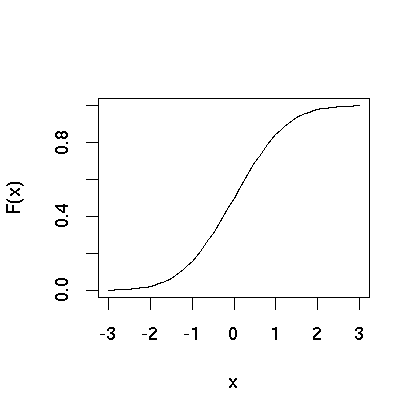

In [2]:
myf = function(t) (1/(sqrt(2*pi)))*exp(-t^2/2)
myF = function(x) integrate(myf, -Inf, x)$value
dom = seq(-3,3,.1)
    options(repr.plot.width=3.5, repr.plot.height=3.5)
plot(dom, sapply(dom, myF), xlab="x", ylab="F(x)", type="l")

The function $f$ defined above is the standard Gaussian _density function_.  We have written code for it already.  It's a little easier to plot it because we coded it in a vectorized way.
(As a mildly advanced exercise, recode `myF` so that it returns a vector of values $F(x)$ for a vector input.)

The density function has a familiar display:

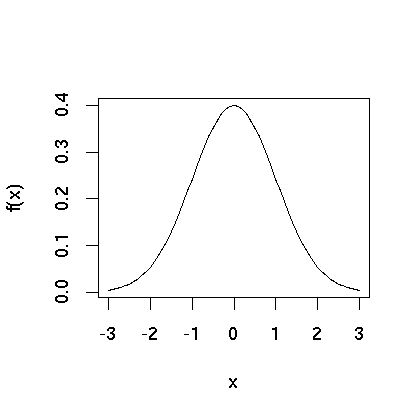

In [3]:
plot(dom, myf(dom), type="l", xlab="x", ylab="f(x)")

R has more general Gaussian density and distribution functions built in, in the sense that
mean and variance values can also be specified to define location and spread.  Here we just show that our handwritten density and the built-in one agree on the points we plotted.

In [4]:
range(myf(dom)-dnorm(dom)) # dnorm is built in

[1] 0 0

### QQ-plots -- visual assessment of distributional model adequacy

If the standard Gaussian model fits data in a vector well, the `qqnorm` function will produce a transformation of the data that is close to the line of identity.

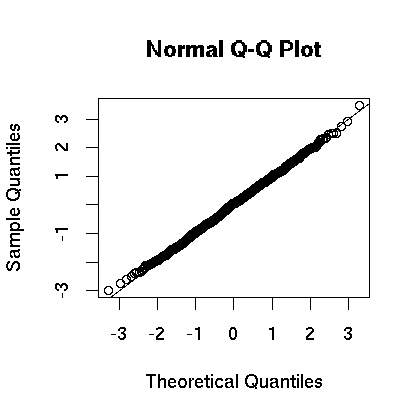

In [5]:
dat = rnorm(1000) # simulated
qqnorm(dat)
abline(0,1)

This idea can be used with data from other distributional models.  See the `qqplot` function, which shows
how a QQ-plot can be used to check for goodness of fit to a chi-squared distribution.

#### Histograms as estimates of densities

A basic tool of exploratory visualization is the histogram.  This can be tuned
in various ways, but let's consider how its default implementation can be used to think about the
plausibility of a model for a given set of data.  We simulate standard
Gaussian observations in R, plot the histogram, and check its relationship to
the theoretical density.

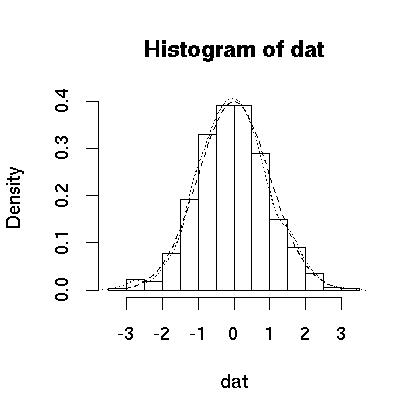

In [6]:
set.seed(1234)
dat = rnorm(1000) # simulated
hist(dat, freq=FALSE)
lines(dom, dnorm(dom), lty=2)
lines(density(dat), lty=3)

Both the default histogram and the default density estimate accurately characterize
variation in the simulated data.  We will now apply them to a classic dataset.

#### Histogram and density with a dataset

R.A. Fisher studied measurements of parts of three species of iris plants.

In [7]:
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


We'll use a histogram and default density estimate to visualize the distribution of petal width.

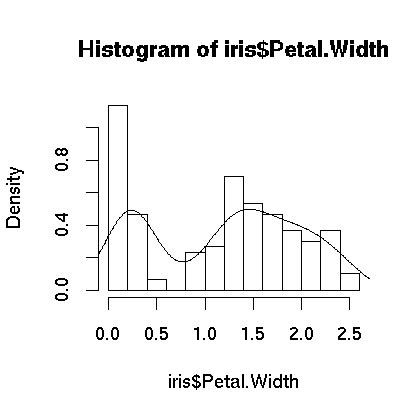

In [8]:
hist(iris$Petal.Width, freq=FALSE)
lines(density(iris$Petal.Width))

Both the histogram and the density serve to demonstrate that a unimodal model 
will not work well for this dataset.  

It is worth noting that the default density display seems particularly flawed in that
it appears to support negative width measures.  (The density sketch extended smoothly
at the left boundary will be positive, but negative values must have probability 0.)  

#### The following material is optional

A density estimation tool that can respect
constraints on the measurement range is available in the logspline package.

In [9]:
if (FALSE) { # change to TRUE if you want to explore this
 library(logspline)  # tell logspline no negative values 
 suppressWarnings(f1 <- logspline(iris$Petal.Width, lbound=0))
 hist(iris$Petal.Width, freq=FALSE)
 dom=seq(0,2.6,.01)
 lines(dom, dlogspline(dom, fit=f1), lty=2)
 lines(density(iris$Petal.Width), lty=3, col="gray")
 legend(1.0, 1.1, legend=c("logspline", "default"), 
       lty=c(2,3), col=c("black", "gray"), bty="n")
}

The histogram is a form of 'nonparametric' density estimation -- it makes no assumptions about the functional form of the underlying distribution.  The logspline density estimate
assumes that there is a smooth underlying density, and constraints like bounds
on the observation space can be imposed.  The default density estimator in R
can be tuned, see `?density`.

As a concluding remark on the value of refined density estimation, we note that the _default_ logspline
estimate was quite suggestive of a trimodal distribution.  We know more about the
iris data than just the measured feature values. Measurements were collected on three different species of plant.  The mean values
of petal width for these species seem to lie close to the local modes suggested by the
logspline estimate.  This is much less apparent with the default density estimate.

In [10]:
#sapply(split(iris$Petal.Width, iris$Species), mean)

In [11]:
if (FALSE) {
hist(iris$Petal.Width, freq=FALSE)
dom=seq(0,2.6,.01)
lines(dom, dlogspline(dom, fit=f1), lty=2)
lines(density(iris$Petal.Width), lty=3, col="gray")
legend(1.0, 1.1, legend=c("logspline", "default"), 
       lty=c(2,3), col=c("black", "gray"), bty="n")
abline(v=c(.246, 1.326, 2.026), lty=4)
}

#### Models and visualization for discrete data

We'll briefly address categorical data that do not have a natural ordering.  A nice
example dataset is the `HairEyeColor` array.


In [12]:
HairEyeColor

, , Sex = Male

       Eye
Hair    Brown Blue Hazel Green
  Black    32   11    10     3
  Brown    53   50    25    15
  Red      10   10     7     7
  Blond     3   30     5     8

, , Sex = Female

       Eye
Hair    Brown Blue Hazel Green
  Black    36    9     5     2
  Brown    66   34    29    14
  Red      16    7     7     7
  Blond     4   64     5     8


We'd like to understand whether eye and hair color are associated, and whether
the association varies by gender.  

#### Two-dimensional problem

To begin, we'll collapse over genders and consider 
a model for the $4 \times 4$ table with hair color in rows and eye color in columns:

In [13]:
hae = apply(HairEyeColor,1:2,sum)
hae

,Brown,Blue,Hazel,Green
Black,68,20,15,5
Brown,119,84,54,29
Red,26,17,14,14
Blond,7,94,10,16


Let $p_{ij}$ denote the joint probability of having hair color $i$ and eye color $j$, let $p_{i\cdot}$
denote the marginal probability of having hair color $i$, and let
$p_{\cdot j}$ denote the marginal probability of having eye color $j$.  The
independence model asserts that $p_{ij} = p_{i\cdot} p_{\cdot j}$ for all $i$ and $j$.  Pearson's Chi-squared statistic measures the goodness of fit of this model.  The `assoc` function of the
vcd package displays the magnitudes of residuals (normalized departures from values expected
under the independence model, see ?assoc for details).

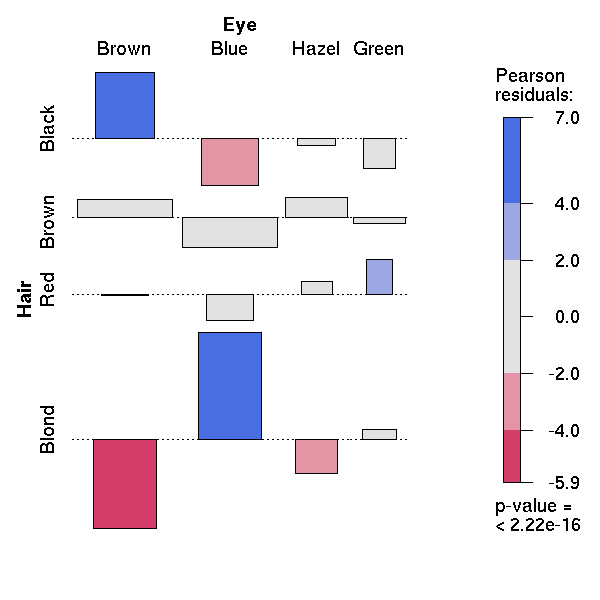

In [14]:
library(vcd)
options(repr.plot.width=5, repr.plot.height=5)
assoc(hae, ~Eye + Hair, shade=TRUE)

#### Three-dimensional problem

To address the full dataset,
we'll use the `mosaicplot` function to examine relative frequencies of different
(sex, eyecolor, haircolor) configurations in the data.  With the `shade` parameter
set, we are presented with a collection of colored rectangles that depict the
relative frequencies of the different categories.  Red boxes correspond to 
configurations that are relatively unusual under the assumption of independence.
Blue boxes correspond to configurations that have unexpectedly high prevalence.

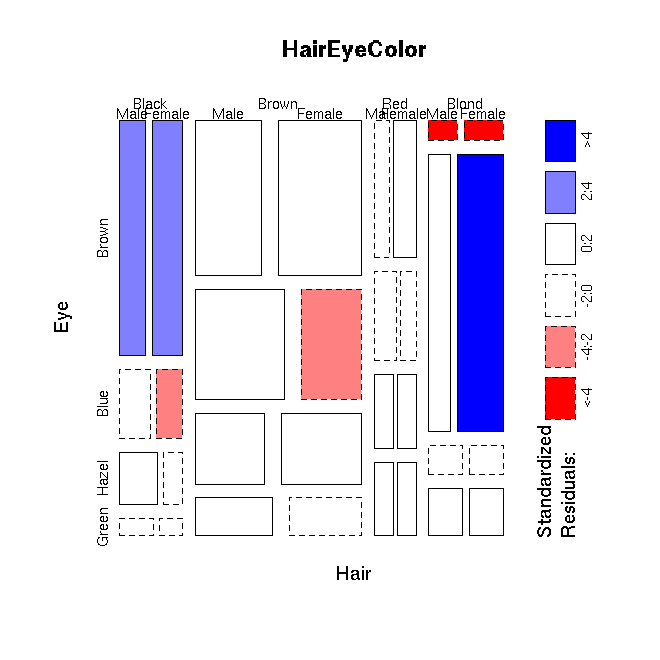

In [15]:
options(repr.plot.width=5.5, repr.plot.height=5.5)
mosaicplot(HairEyeColor, shade=TRUE)

The colored residual rectangles can be
read to indicate that there are fewer blond-haired brown-eyed individuals than expected under
an assumption of independence. The combination of black hair and brown eyes occurs more commonly than
would be expected under this assumption.  The discipline of [log-linear modeling](https://books.google.com/books?id=Td5dhfwi31EC&source=gbs_book_other_versions)
and [formalism on the chi-squared test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test) can be reviewed to get a deeper understanding of this technique.

## A quick survey of R's base graphics for multivariate data

### Additional views of Fisher's iris data

We focused before on a single feature.  The full dataset has four features and species label.

In [16]:
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


#### Marginal distributions

Using base R to visualize a group of distributions can lead to complications even
when something as simple as the boxplot is in use.  The defaults for the display below
lead to dropping a species label in each plot.  We need to rotate the labels to have
them fit in the available margin space.

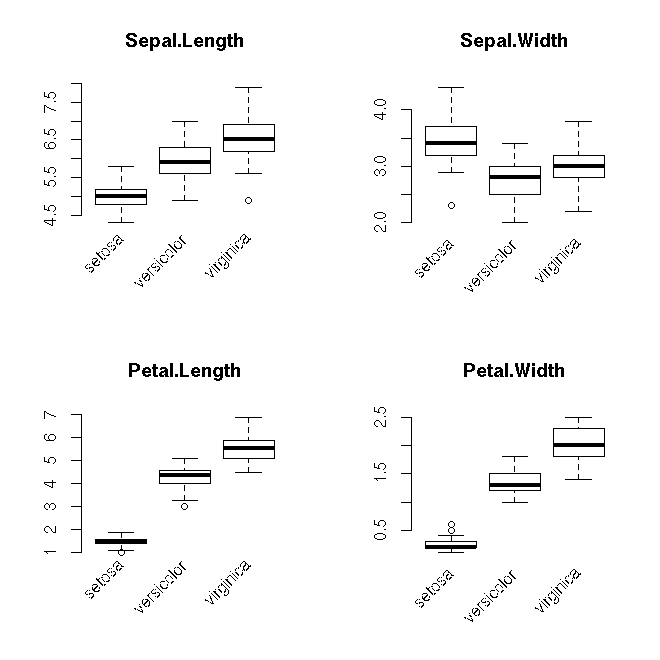

In [17]:
par(mfrow=c(2,2))
for (i in 1:4) {
      boxplot(split(iris[,i], iris$Species),
         main=names(iris)[i], axes=FALSE)
      axis(2)
      text(1:3, par("usr")[3] - 0.25, srt = 45, adj = 1,
          labels = levels(iris$Species), xpd = TRUE)
      }


It is often of interest to visualize the individual data points.  The beeswarm
algorithm is easy to use.

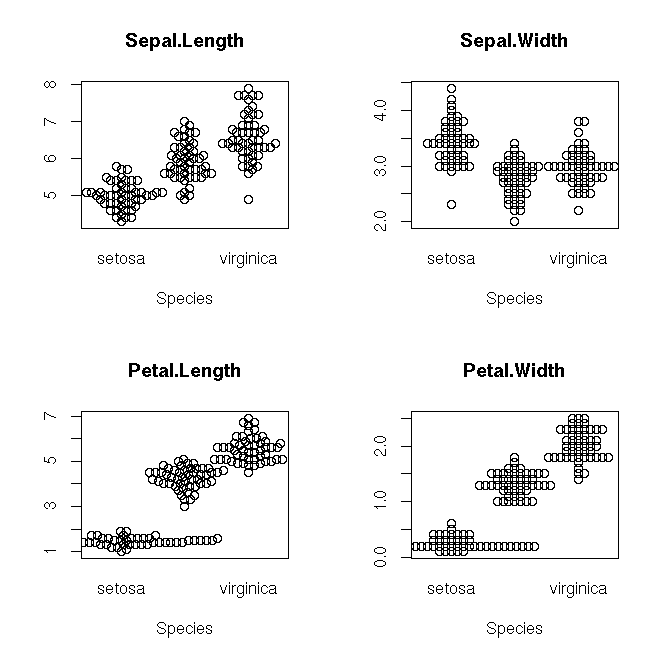

In [18]:
library(beeswarm)
par(mfrow=c(2,2))
for (i in 1:4) beeswarm(iris[,i]~Species, 
        data=iris, main=names(iris)[i], ylab=" ")

Exercise.  Fix the code just above so that all species labels appear.

#### Bivariate distributions

The formula notation is a natural one to use for simple scatterplots.  Because the
data are recorded to only one decimal place, we use `jitter` to reduce overplotting.

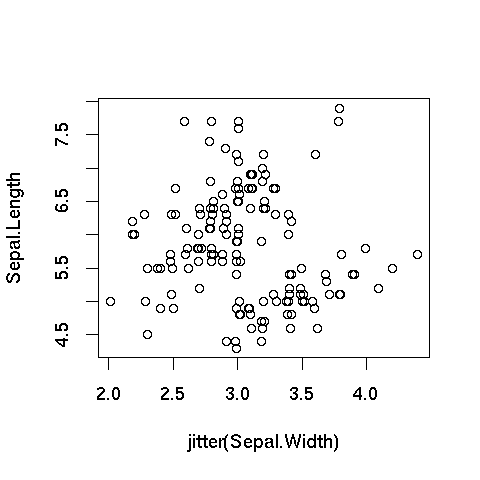

In [19]:
par(mfrow=c(1,1))
options(repr.plot.width=4, repr.plot.height=4) # specific for jupyter
plot(Sepal.Length~jitter(Sepal.Width), data=iris)

Additional parameters can be given to alter the appearance.

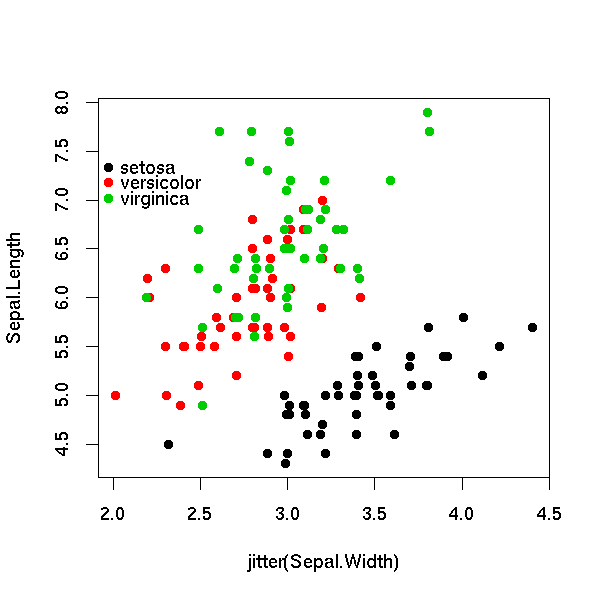

In [20]:
options(repr.plot.width=5, repr.plot.height=5)
plot(Sepal.Length~jitter(Sepal.Width), data=iris, pch=19, col=Species)
legend(1.9, 7.5, col=1:3, pch=19, legend=levels(iris$Species), bty="n")

For a modest number of features, `pairs` provides all pairwise scatterplots.

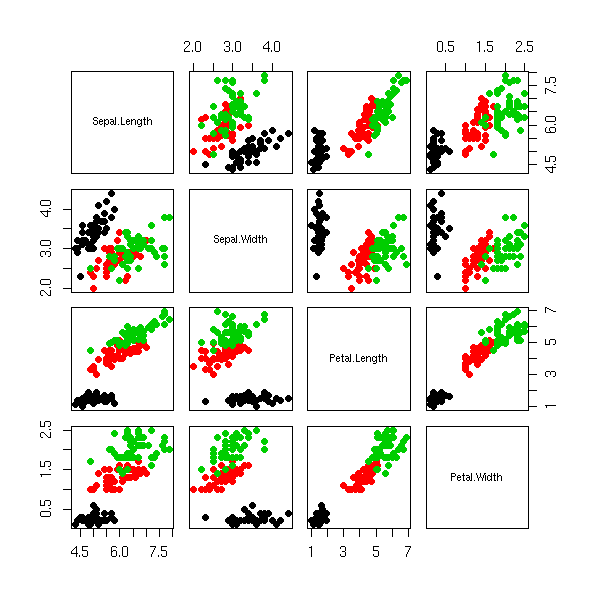

In [21]:
pairs(iris[,-5], col=iris$Species, pch=19, cex.labels=.9)

### A cluster analysis

Simple unsupervised analysis of multivariate data can be conducted with
the cluster package.  Symbols are used to distinguish cluster assignments,
and, in the call used here, color is used to discriminate the species 
by which samples are labeled.  The 4-dimensional data are projected to the
plane defined by the first two principal components.


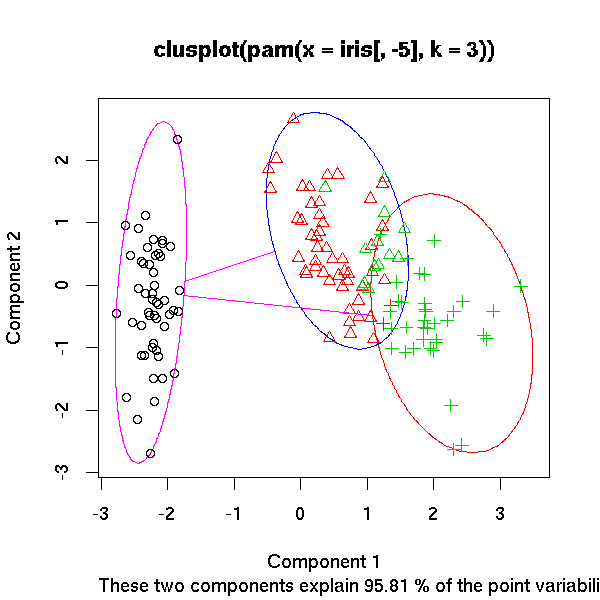

In [22]:
library(cluster)
c1 = pam(iris[,-5], 3)
plot(c1, col=TRUE, col.p=iris$Species, which=1)

## ggplot2: an implementation of a grammar of graphics

Base graphics in R have primary interfaces `plot`, `lines`, `points`, `par`.

Leland Wilkinson proposed a grammatical way of thinking about statistical visualization, and
Hadley Wickham's ggplot2 package implements features of this grammatical model.

We start with a data.frame instance in which rows define samples and columns define features.
Key components of the model are  `stats`, which define data reductions of use for
display, `geoms`, which are types of renderings of stats that will ultimately
display in the plane, `aes`, a specification of how data elements map to components
of `stats` and `geoms`, and `facets`, that organize groups of displays.

The easiest way to get a grip on this is to plunge in.  Let's work with the iris data
for concreteness.  We'll create one- and then two-dimensional histograms for iris features.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


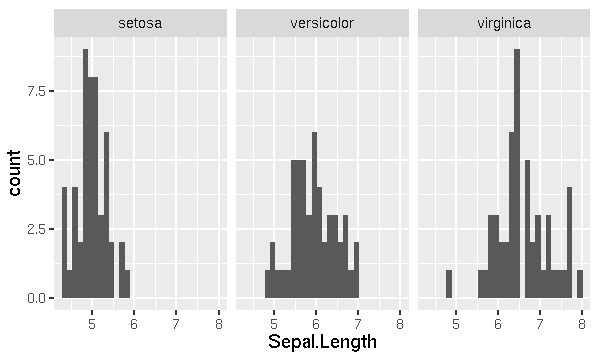

In [23]:
options(repr.plot.height=3) # specific for jupyter
ggplot(iris, aes(x=Sepal.Length)) + geom_histogram() + facet_grid(~Species)

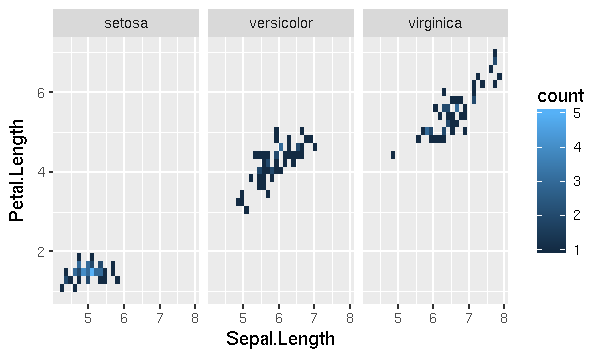

In [24]:
ggplot(iris, aes(x=Sepal.Length, y=Petal.Length)) + geom_bin2d() + facet_grid(~Species)

We see the pattern, that is somewhat unusual given what we've done with R so far

- we start by evaluating `ggplot` on a data.frame with some additional parameters
- we use `+` to add specifications to the visualization
- evaluating the resulting expression produces the rendering

There is one more feature of ggplot2 that we will not discuss: the definition of `autoplot` methods that compose ggplot commands relevant to instances of specific classes.  We'll
encounter this in the next section.


### Exercise

The following display shows how we can enhance views of bivariate scatter using density contours, using
the algebraic approach to plot enhancement afforded by ggplot2.

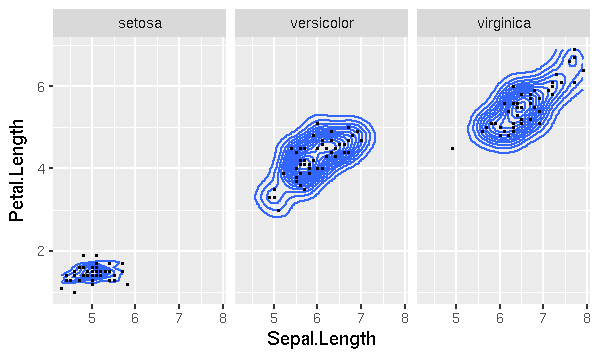

In [25]:
g1 = ggplot(iris, aes(x=Sepal.Length, y=Petal.Length)) + geom_density2d() + facet_grid(~Species)
g1 + geom_point(size=.5)

In [26]:
# remove the comments with your modifications
# ir2 = subset(iris, ...
#
# g1 = ggplot(ir2, aes(x=jitter(Sepal.Length), y=jitter(Petal.Length))) + geom_density2d()
# g1 + ...   #
# boxplot(ir2$Petal.Length) # any boxplot outliers?

## ggbio

The [ggbio](http://www.bioconductor.org/packages/ggbio) package has a number of `autoplot` methods for various types of genomic data.  `autoplot` methods can be created very flexibly
to define ggplot2 rendering interfaces tailored to particular
data classes.

### Genome-wide surveys

It is relatively easy to obtain a view over chromosomes of data in a GRanges.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


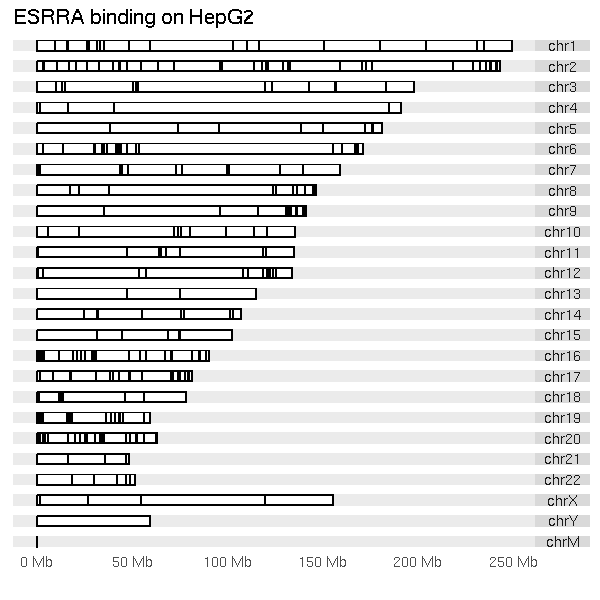

In [27]:
options(repr.plot.height=5)
library(ERBS)
data(HepG2)
library(GenomeInfoDb)  # trim all but autosomal chroms
HepG2 = keepStandardChromosomes(HepG2)
data(GM12878)
GM12878 = keepStandardChromosomes(GM12878)
library(ggbio)
autoplot(HepG2, layout="karyogram", main="ESRRA binding on HepG2")

### Visualizing gene models.

Particularly in RNA-seq studies, it is useful to be able to
see the diversity of transcript forms corresponding to genes.  Again
an autoplot method can be used.

We'll set up by getting a convenient representation of gene addresses from
[biovizBase](http://www.bioconductor.org/packages/biovizBase).

In [28]:
library(ggbio)
library(Homo.sapiens)
data(genesymbol, package="biovizBase") # a set of GRanges for gene regions
genesymbol

GRanges object with 29177 ranges and 2 metadata columns:
               seqnames                 ranges strand |       symbol
                  <Rle>              <IRanges>  <Rle> |  <character>
          A1BG    chr19   [58858174, 58864865]      - |         A1BG
           A2M    chr12   [ 9220304,  9268558]      - |          A2M
          NAT1     chr8   [18027971, 18081197]      + |         NAT1
          NAT1     chr8   [18067618, 18081197]      + |         NAT1
          NAT1     chr8   [18079177, 18081197]      + |         NAT1
           ...      ...                    ...    ... .          ...
  LOC100499405    chr12 [  9392599,   9395645]      + | LOC100499405
  LOC100499467    chr17 [ 70399463,  70588943]      - | LOC100499467
      C9orf174     chr9 [100069910, 100139575]      + |     C9orf174
  LOC100499484     chr9 [100000708, 100059594]      + | LOC100499484
  LOC100499489    chr10 [ 22724354,  22726858]      - | LOC100499489
                    ensembl_id
               

We'll pick two genes of interest and use an enhancement to an autoplotted object to get the visualization.

Parsing transcripts...
Parsing exons...
Parsing cds...
Parsing utrs...
------exons...
------cdss...
------introns...
------utr...
aggregating...
Done
'select()' returned 1:1 mapping between keys and columns
Constructing graphics...


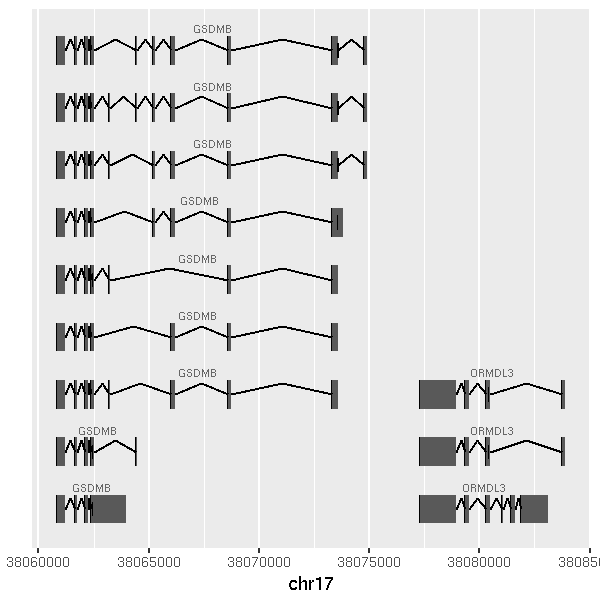

In [29]:
oo = genesymbol[c("ORMDL3", "GSDMB")]
ap1 = autoplot(Homo.sapiens, which=oo, gap.geom="chevron")
attr(ap1, "hasAxis") = TRUE
ap1 + xlab("chr17")

The following code chunk defines a function that uses ggbio to visualize binding site locations
in the context of gene models.  Unfortunately it runs pretty slowly so we will skip it for now.

In [30]:
if (FALSE) {  # slow
options(repr.plot.height=4)
library(ERBS)
data(GM12878)
vizBsByGene = function(brngs, sym="ATP5D", radius=5000, label) {
   require(biovizBase)
   if (!exists("genesymbol")) data(genesymbol, package="biovizBase")
   pl = try(genesymbol[sym])
   if (inherits(pl, "try-error")) stop("symbol not found")
   ap2 = autoplot(Homo.sapiens, which=pl+radius, gap.geom="chevron")
   ss <- subsetByOverlaps(brngs, pl+radius)
   if (length(ss)==0) stop("no binding sites near gene")
   ap3 = autoplot(ss) 
   ch = as.character(seqnames(pl)[1])
   vl = list(ap3, TX=ap2)
   names(vl)[1] = label
   tracks(vl, heights=c(1,3)) 
}
vizBsByGene( GM12878, sym="ATP5D", label="ESRRA bnds")
}

## Gviz for flexible high-level visualizations

### Assay values juxtaposed with genes

Here we define and call a function that uses [Gviz](http://www.bioconductor.org/packages/Gviz) to show
binding sites in context of gene regions.  The key elements are

- DataTrack, which processes a GRanges with numerical metadata
- GeneRegionTrack, which generates a display of a GRanges assumed to provide gene addresses
- IdeogramTrack, which shows context of visualization on a chromosome with its cytoband layout sketched in
- GenomeAxisTrack, which gives the basic coordinates of the current visualization
- plotTracks, which will render a list of \*Track entities

Warning message in grid.Call.graphics(C_rect, x$x, x$y, x$width, x$height, resolveHJust(x$just, :
"semi-transparency is not supported on this device: reported only once per page"

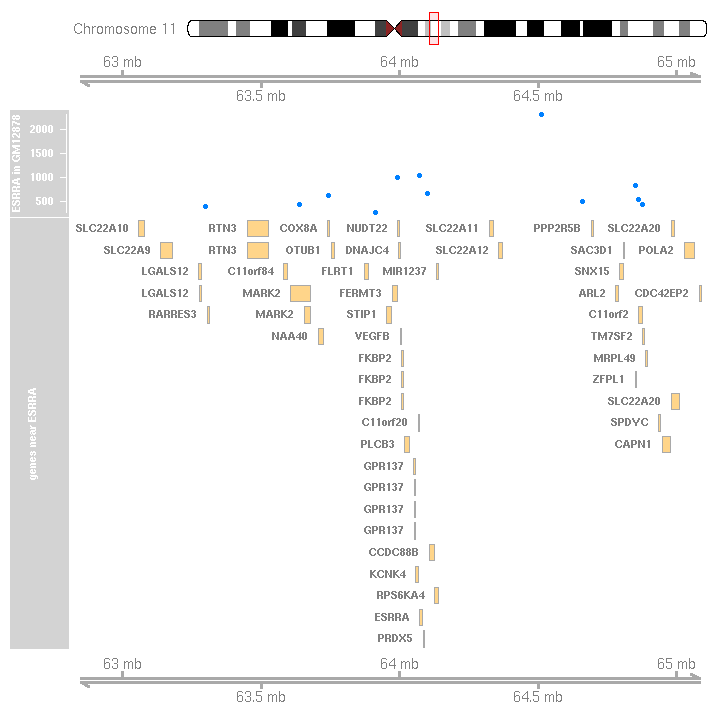

In [31]:
options(repr.plot.height=6, repr.plot.width=6)
bsNearGene = function(bsgr, sigmcol="peak", sym="ESRRA", 
    datalab, reflab, radius=500000, genome="hg19") {
 requireNamespace("biovizBase")
 data(genesymbol, package="biovizBase")
 loc = genesymbol[sym]
 neigh = subsetByOverlaps(genesymbol, loc+radius)
 sc = subsetByOverlaps(bsgr, range(neigh))
 dt = DataTrack(sc[,sigmcol], name=datalab)
 grt = GeneRegionTrack( neigh, showId=TRUE, name=reflab)
 idx = IdeogramTrack(genome=genome, chr=as.character(seqnames(loc)))
 gat = GenomeAxisTrack()
 plotTracks(list(idx, gat, dt, grt, gat))
}
library(ERBS)
data(GM12878)
data(HepG2)
bsNearGene(GM12878, datalab="ESRRA in GM12878", sym="ESRRA", reflab="genes near ESRRA", radius=1000000)

## Conclusions

We review the road map annotated with some relevant functions for recall.

```
Road map:
  - Purpose of visualization: exhibit the structure of variation
  - Statistical modeling concepts
      - Gaussian density and distribution functions
          - dnorm, integrate, qnorm; rnorm for simulation
      - QQ-plot to check adequacy of a distributional model
          - qqnorm, qqplot
      - histogram and density estimation
          - hist(), density()
      - Categorical data: contingency tables and tests of independence
          - mosaicplot, vcd::assoc
  - Multivariate visualization concepts
      - comparing boxplots
      - scatterplot, pairs plot
      - visualizing clusters after dimension reduction
          - cluster::pam
  - Grammar of graphics sketched
          - ggplot, aes, geom_*
  - ggbio
          - autoplot
  - Gviz: a sashimi plot for paired-end RNA-seq
          - DataTrack, GeneRegionTrack, GenomeAxisTrack, plotTracks
```

### Appendix: Controlling base graphics via par()

There are many parameters that control the display of standard R graphics.  See ?par for details.  Some frequently used are cex (character expansion factor), mar (set margins), mfrow (setup a multipanel display), pch (choose plotting glyph), las (alter angle of marginal label rendering).

```
> sort(names(par()))
 [1] "adj"       "ann"       "ask"       "bg"        "bty"       "cex"      
 [7] "cex.axis"  "cex.lab"   "cex.main"  "cex.sub"   "cin"       "col"      
[13] "col.axis"  "col.lab"   "col.main"  "col.sub"   "cra"       "crt"      
[19] "csi"       "cxy"       "din"       "err"       "family"    "fg"       
[25] "fig"       "fin"       "font"      "font.axis" "font.lab"  "font.main"
[31] "font.sub"  "lab"       "las"       "lend"      "lheight"   "ljoin"    
[37] "lmitre"    "lty"       "lwd"       "mai"       "mar"       "mex"      
[43] "mfcol"     "mfg"       "mfrow"     "mgp"       "mkh"       "new"      
[49] "oma"       "omd"       "omi"       "page"      "pch"       "pin"      
[55] "plt"       "ps"        "pty"       "smo"       "srt"       "tck"      
[61] "tcl"       "usr"       "xaxp"      "xaxs"      "xaxt"      "xlog"     
[67] "xpd"       "yaxp"      "yaxs"      "yaxt"      "ylbias"    "ylog"     
```